# NYPD Final Project

author: Anna Czartoszewska \
student id: 420600 \
email: a.czartoszewsk@student.uw.edu.pl

This notebook uses data on:
- population (as of 31 Dec 2024; 3 datasets from 3 separate tables with division by voivodship (table II), powiat (table III) and gmina (table IV)); file names: 'data_population_woj.xls', 'data_population_pow.xls', 'data_population_gm.xls',
- area of territory units (as of 1 Jan 2025, 3 levels of territory units: voivodship, powiat and gmina); file name: 'data_area.xlsx',
- alcohol permits (as of 4 Feb 2025, with information about voivodship); file name: 'data_alcohol_stores.csv',
- fire events (as of 1 Feb 2025, with division by voivodship, powiat and gmina, and by object code); file name: 'data_fire_events.csv'

in Poland. The data is publicly available.

Sources:
- population: https://stat.gov.pl/obszary-tematyczne/ludnosc/ludnosc/ludnosc-stan-i-struktura-ludnosci-oraz-ruch-naturalny-w-przekroju-terytorialnym-w-2024-r-stan-w-dniu-31-12,6,38.html
- area od territory units: https://dane.gov.pl/pl/dataset/1447,oficjalny-wykaz-pol-powierzchni-geodezyjnych-wojewodztw-powiatow-i-gmin/resource/66239/table
- alcohol permits: https://dane.gov.pl/pl/dataset/1191,informacja-o-przedsiebiorcach-posiadajacych-zezwolenia-na-handel-hurtowy-napojami-alkoholowymi-1/resource/64402/table?page=1&per_page=20&q=&sort=
- fire events: https://dane.gov.pl/pl/dataset/4695/resource/64722/table?page=1&per_page=20&q=&sort=

The analysis contains of:
- loading and inspecting the datasets,
- preparing datasets for further analysis - keeping only the relevant information, dropping NaN rows, renaming columns,
- concatenating information into one dataframe for correlation analysis,
- plotting barplots of variables of interest (only for voivodship level),
- plotting comparative normalised barplot of the variables (only for voivodship level),
- plotting correlation matrices,
- performing correlation analysis.

The notebook uses functions from data_analysis_package, prepared to be used with this data. Path to folder containing data files is specified in the first code cell. All the results, including basic statistics table, plots and correlation analysis results are saved in the output folder (analysis results in the file specified in the first code cell).

### Imports, setup

Importing libraries and package modules, setting display option and folder path and file name variables.

In [2]:
!pip install data_analysis_package

In [3]:
import pandas as pd
from data_analysis_package import data_prep as dp, statistics_functions as stf

pd.set_option('display.max_columns', 15)

data_folder_path = 'data'
territory_level = 'v'
file_list = ['data_population_'+territory_level+'.xls', 'data_area.xlsx', 'data_alcohol_stores.csv', 'data_fire_events.csv']
output_folder_path = 'output'
output_file = 'corr_results.txt'

### Data preparation

Loading full datasets.


In [4]:
df_population_all, df_area_all, df_alcohol_all, df_fire_events_all = dp.load_data(data_folder_path, file_list)

Inspecting the datasets to see what kind of data and what columns are there, if there is any missing information etc.

Creating dataframes with relevant data and changed columns' names. For clarity, I present all the operations, but in the package there is a function dp.relevant_data_prep_and_rename(df_population_all, df_area_all, df_alcohol_all, df_fire_events_all) where those adjustments are made.

**Population**

In [5]:
dp.data_inspection(df_population_all)

-------Data inspection------- 

1. First 10 rows: 
  Województwa\nVoivodships  \
0                      NaN   
1                      NaN   
2                      NaN   
3        POLSKA   \nPOLAND   
4             Dolnośląskie   
5       Kujawsko-pomorskie   
6                Lubelskie   
7                 Lubuskie   
8                  Łódzkie   
9              Małopolskie   

   Ludność\n(stan w dniu 31.12)\nPopulation\n(as of \nDecember 31)  \
0                                                NaN                 
1                                                NaN                 
2                                                NaN                 
3                                         37489087.0                 
4                                          2868242.0                 
5                                          1984479.0                 
6                                          1996440.0                 
7                                           969819.0      

We see that rows with missing data are empty in all the columns, so we drop them. There are no irrelevant columns so we only rename them.

In [6]:
df_population_all.dropna(inplace=True) # remove empty rows
df_population = df_population_all[['Województwa\nVoivodships', 'Ludność\n(stan w dniu 31.12)\nPopulation\n(as of \nDecember 31)']].copy() # make a copy of the original df (relevant columns)
df_population.rename(columns={"Województwa\nVoivodships": "Voivodship", "Ludność\n(stan w dniu 31.12)\nPopulation\n(as of \nDecember 31)": "Population"}, inplace=True) # rename the columns
print(df_population.head()) # see the first 5 rows

           Voivodship  Population
3   POLSKA   \nPOLAND  37489087.0
4        Dolnośląskie   2868242.0
5  Kujawsko-pomorskie   1984479.0
6           Lubelskie   1996440.0
7            Lubuskie    969819.0


**Area**

In [7]:
dp.data_inspection(df_area_all)

-------Data inspection------- 

1. First 10 rows: 
        TERYT                Nazwa jednostki  Powierzchnia [ha]  \
0          00                         POLSKA           31393293   
1          02              WOJ. DOLNOŚLĄSKIE            1994714   
2     02 01             Powiat bolesławiecki             130351   
3  02 01 01 1                    Bolesławiec               2285   
4  02 01 02 2                    Bolesławiec              28913   
5  02 01 03 2                       Gromadka              26775   
6  02 01 04 3                   Nowogrodziec              17663   
7  02 01 04 4          Nowogrodziec - miasto               1610   
8  02 01 04 5  Nowogrodziec - obszar wiejski              16053   
9  02 01 05 2                     Osiecznica              43669   

   Powierzchnia [km2]  
0              313933  
1               19947  
2                1304  
3                  23  
4                 289  
5                 268  
6                 177  
7                  

Since 'Area [km2]' and 'Area [ha]' contain the same infromation, I decide to keep only the area in km2.

In [8]:
df_area = df_area_all.copy() # make a copy of the original df
df_area.rename(columns={'TERYT': "Territory code", "Nazwa jednostki": "Unit name", "Powierzchnia [ha]": "Area [ha]", "Powierzchnia [km2]": "Area [km2]"}, inplace=True)  # rename the columns
df_area.drop(columns=['Area [ha]'], inplace=True) # drop area in ha
print(df_area.head()) # see the first 5 rows

  Territory code             Unit name  Area [km2]
0             00                POLSKA      313933
1             02     WOJ. DOLNOŚLĄSKIE       19947
2        02 01    Powiat bolesławiecki        1304
3     02 01 01 1           Bolesławiec          23
4     02 01 02 2           Bolesławiec         289


**Alcohol selling companies**


In [9]:
dp.data_inspection(df_alcohol_all)

-------Data inspection------- 

1. First 10 rows: 
  Numer zezwolenia                                        Nazwa firmy  \
0           394/23      AMKA  Spółka z ograniczoną odpowiedzialnością   
1           404/23   WORMAR K Spółka z ograniczoną odpowiedzialnością   
2           407/23                                    RAFAŁ DZILIŃSKI   
3           5/W/24  ALKOSWIAT Spółka z ograniczoną odpowiedzialnością   
4           6/W/24             Matyl Fenikost Aleksadra Matyl-Stawowy   
5             8/24  "AUCHAN POLSKA"  Spółka z ograniczoną odpowied...   
6            15/24  Manufaktura Nalewek  Spółka z ograniczoną odpo...   
7            18/24  CERVILLE INVESTMENTS  Spółka z ograniczoną odp...   
8            19/24  "PHU WYSOKIŃSKI"  Spółka z ograniczoną odpowie...   
9            20/24   FILABORA  FB  KOŁPA  & KOŁPA SPÓŁKA  KOMANDYTOWA   

  Kod pocztowy    Miejscowość                         Adres  \
0       02-972       Warszawa  Aleja Rzeczypospolitej 18/83   
1       83-300     

Keeping only 'numer zezwolenia' (renaming to 'permit number') as an id and 'województwo' (renaming to 'voivodship'), not removing any rows, as ther is no missing data.

In [10]:
df_alcohol = df_alcohol_all[['Numer zezwolenia', 'Województwo']].copy() # make a copy of the original df (relevant columns)
df_alcohol.rename(columns={"Numer zezwolenia": "Permit number", "Województwo": "Voivodship"}, inplace=True) # rename the columns
print(df_alcohol.head()) # see the first 5 rows

  Permit number        Voivodship
0        394/23  WOJ. MAZOWIECKIE
1        404/23    WOJ. POMORSKIE
2        407/23  WOJ. MAZOWIECKIE
3        5/W/24      WOJ. ŚLĄSKIE
4        6/W/24  WOJ. MAŁOPOLSKIE


**Fire events**

In [11]:
dp.data_inspection(df_fire_events_all)

-------Data inspection------- 

1. First 10 rows: 
   TERYT   Województwo          Powiat                Gmina  \
0  20101  dolnośląskie   bolesławiecki          Bolesławiec   
1  20102  dolnośląskie   bolesławiecki          Bolesławiec   
2  20103  dolnośląskie   bolesławiecki             Gromadka   
3  20104  dolnośląskie   bolesławiecki         Nowogrodziec   
4  20105  dolnośląskie   bolesławiecki           Osiecznica   
5  20106  dolnośląskie   bolesławiecki  Warta Bolesławiecka   
6  20201  dolnośląskie  dzierżoniowski              Bielawa   
7  20202  dolnośląskie  dzierżoniowski          Dzierżoniów   
8  20203  dolnośląskie  dzierżoniowski             Pieszyce   
9  20204  dolnośląskie  dzierżoniowski         Piława Górna   

   OGÓŁEM Liczba zdarzeń  RAZEM 1. Obiekty użyteczności publicznej  \
0                     79                                         2   
1                     75                                         1   
2                     66                     

Keeping only columns with information about voivodship name and number, powiat, gmina and total number of fire events (dropping information on the specific types as ther is a lot of them and it's not very informative).

In [12]:
df_fire_events = df_fire_events_all[['TERYT', 'Województwo', 'Powiat', 'Gmina', 'OGÓŁEM Liczba zdarzeń']].copy() # make a copy of the original df (relevant columns)
# 'RAZEM 6. Lasy (państwowe i prywatne)'
df_fire_events.rename(columns={"TERYT":"Territory code", "Województwo": "Voivodship", "OGÓŁEM Liczba zdarzeń": "Total number of fires"}, inplace=True) # rename the columns
print(df_fire_events.head()) # see the first 5 rows

   Territory code    Voivodship         Powiat         Gmina  \
0           20101  dolnośląskie  bolesławiecki   Bolesławiec   
1           20102  dolnośląskie  bolesławiecki   Bolesławiec   
2           20103  dolnośląskie  bolesławiecki      Gromadka   
3           20104  dolnośląskie  bolesławiecki  Nowogrodziec   
4           20105  dolnośląskie  bolesławiecki    Osiecznica   

   Total number of fires  
0                     79  
1                     75  
2                     66  
3                    155  
4                     41  


### Analysis

Keeping only the information related to voivodships and concatenating it in one dataframe 'df_voi'. Also making the values in the column related to voivodships' names consistent across dataframes (in the format 'WOJ. NAME'). It's all contained in dp.by_voivodship(df_population, df_area, df_alcohol, df_fire_events). The operations are:

Alcohol permits:
- group by voivodship, counting the events,
- rename column 'Permit number' to 'Total number of alcohol permits'.

Fire events:
- group by voivodship, summing the total numer of fires,
- drop territory code (there are codes also in the area dataframe, I keep those)
- change the values in the voivodship column to match the other dataframes (uppercase with 'WOJ.' in the beginning)

Population:
- keep only the rows with voivodship name in the 'Voivodship' (ending with 'kie') column, group by voivodship, using max of population (there are 3 categories: total, city, country),
- change the values in the voivodship column to match the other dataframes (uppercase with 'WOJ.' in the beginning)

Area:
- choose only the values related to voivodships ('unit name' column value starting with 'WOJ.')
- rename column 'Unit name' to 'Voivodship'

Merging the dataframes on index, which is set to voivodship in all the dataframes.


In [13]:
df_voi, df_population_voi, df_area_voi, df_alcohol_voi, df_fire_events_voi = dp.by_voivodship(df_population, df_area, df_alcohol, df_fire_events)

The merged dataset:

In [14]:
df_voi

,Territory code,Area [km2],Population,Total number of alcohol permits,Total number of fires
Voivodship,,,,,
WOJ. DOLNOŚLĄSKIE,02,19947,2868242.0,18,10957
WOJ. KUJAWSKO-POMORSKIE,04,17971,1984479.0,13,5223
WOJ. LUBELSKIE,06,25122,1996440.0,13,5675
WOJ. LUBUSKIE,08,13988,969819.0,4,3476
WOJ. MAZOWIECKIE,14,35559,5508322.0,129,17321
WOJ. MAŁOPOLSKIE,12,15184,3429084.0,43,6849
WOJ. OPOLSKIE,16,9412,930296.0,6,2641
WOJ. PODKARPACKIE,18,17845,2062997.0,12,5078
WOJ. PODLASKIE,20,20187,1132641.0,13,3187


Calculating basic statistics (mean, std, min, 50%, max) about the numeric data (without territory code).

In [15]:
stat_table = stf.statistics_table(df_voi)
stat_table

,Area [km2],Population,Total number of alcohol permits,Total number of fires
mean,19620.88,2343067.94,26.00,6477.44
std,6829.35,1294815.75,30.81,3724.07
min,9412.00,930296.00,4.00,2641.00
50%,18883.00,2029718.50,14.00,5447.50
max,35559.00,5508322.00,129.00,17321.00


### Plots


Creating basic plots.

1. Histograms of the variables of interest.

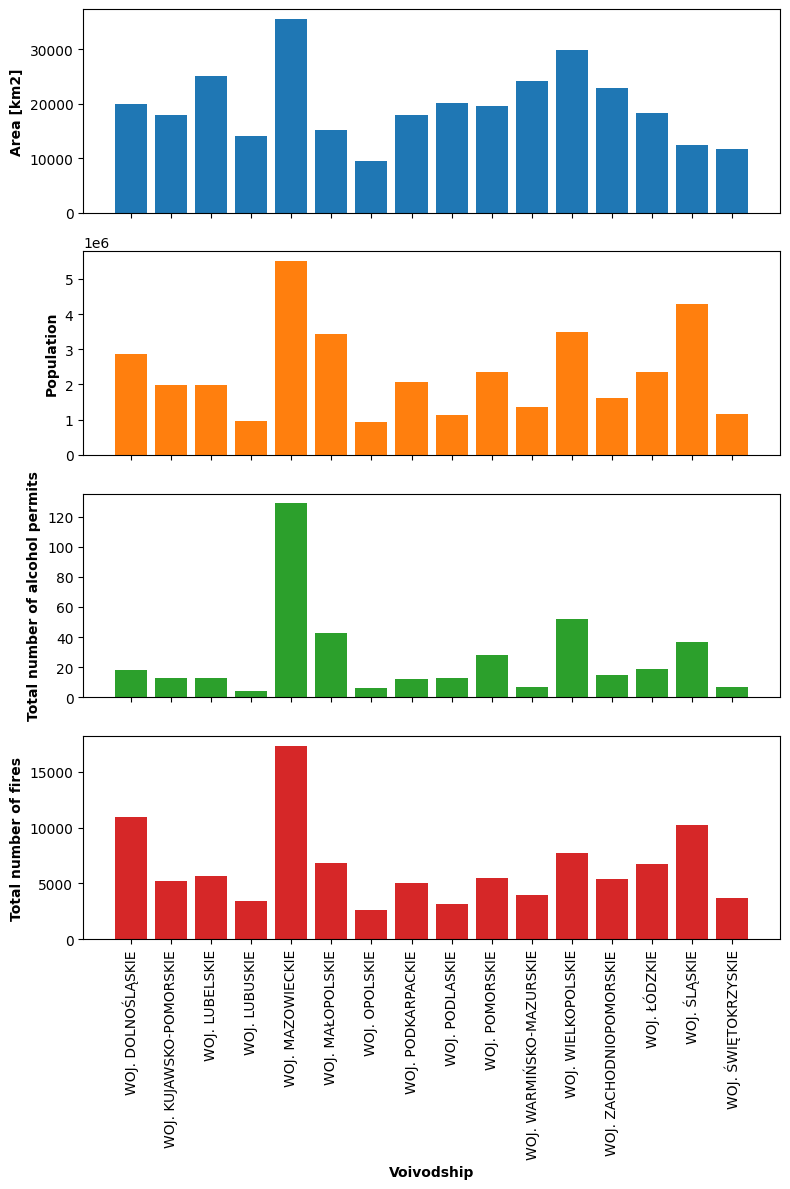

In [16]:
stf.barplots(df_voi, cols=['Area [km2]', 'Population', 'Total number of alcohol permits', 'Total number of fires'], output_folder=output_folder_path)

2. One comparative histogram of the variables of interest with normalised values.

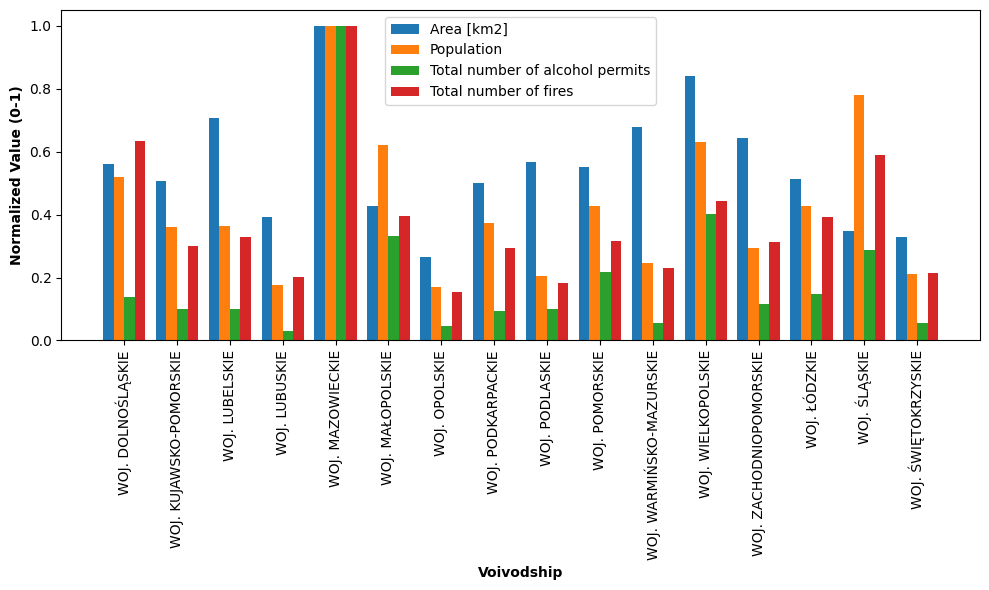

In [17]:
stf.normalised_barplot(df_voi, cols=['Area [km2]', 'Population', 'Total number of alcohol permits', 'Total number of fires'], output_folder=output_folder_path)

### Correlation analysis

Let us look at the correlations between the variables in the dataframes and at the correlations between the densities of the variables (apart from the area).

Plotting the correlations of all the variables of interest:


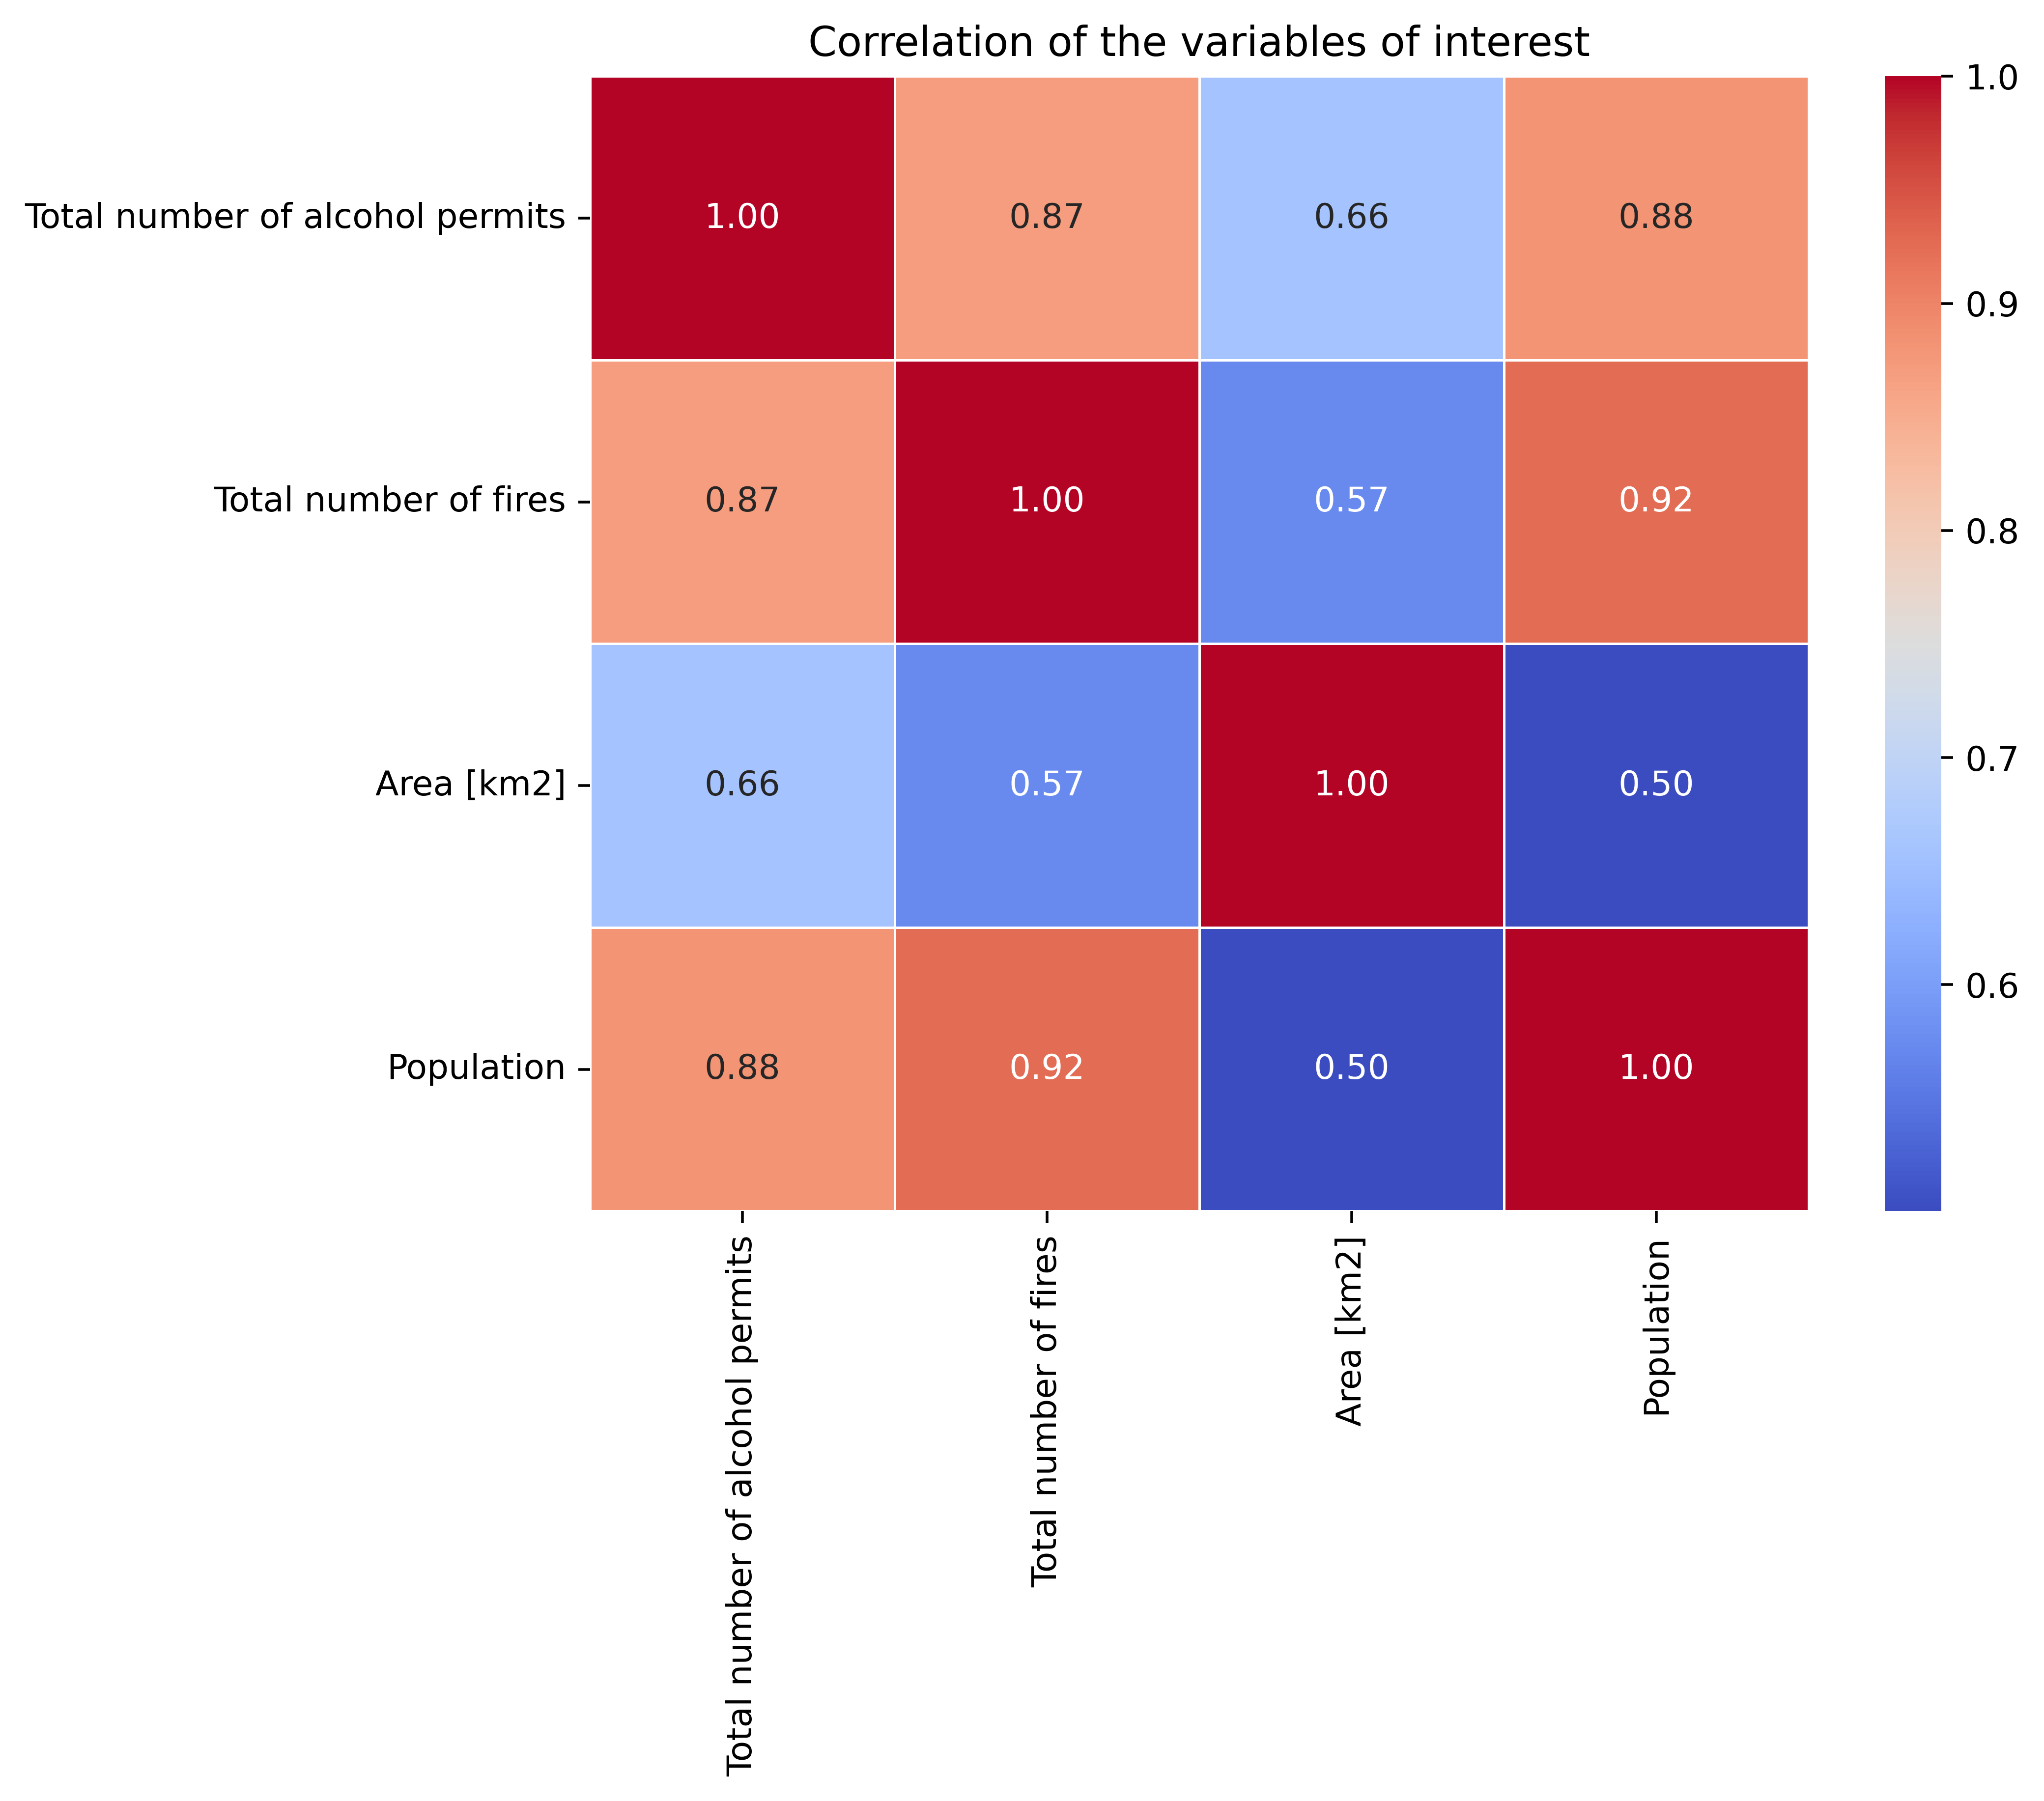

In [18]:
stf.corr_plot(df_voi, ['Total number of alcohol permits', 'Total number of fires', 'Area [km2]', 'Population'], output_folder=output_folder_path, filename='corr_voi.png')

Plotting the correlations between densities.

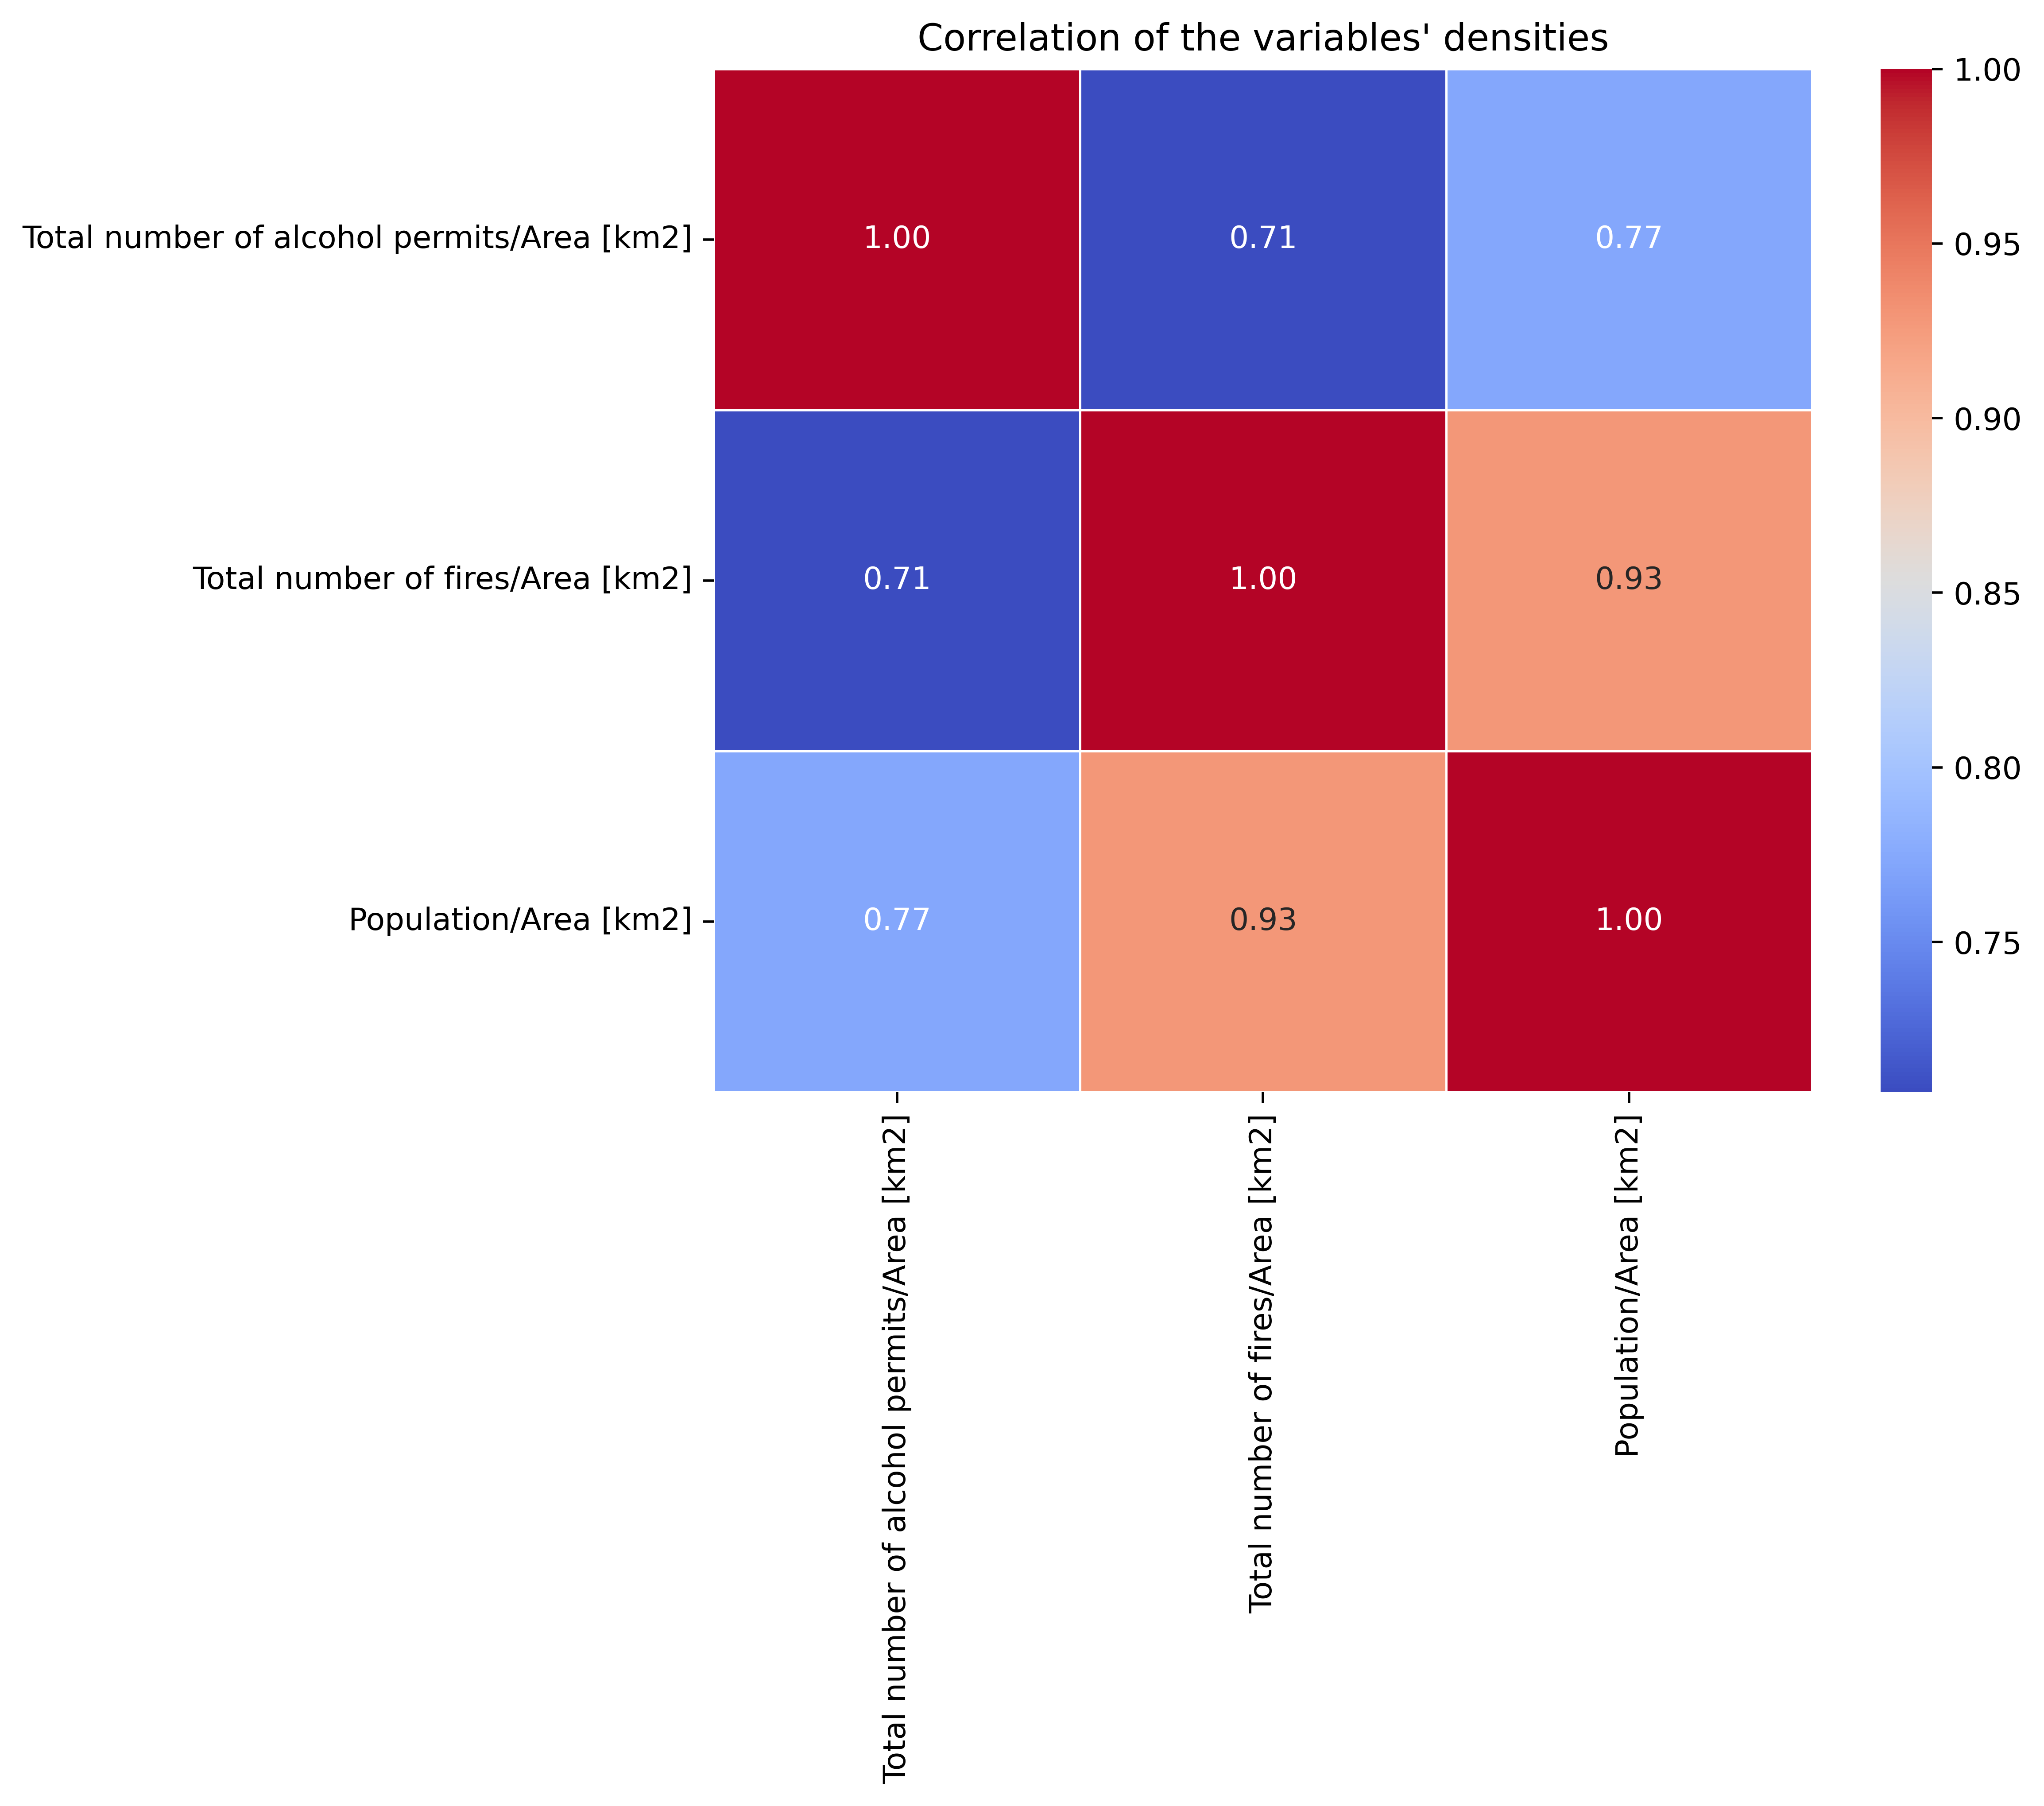

In [19]:
stf.density_corr_plot(df_voi.copy(), ['Total number of alcohol permits', 'Total number of fires', 'Population'], area='Area [km2]', output_folder=output_folder_path, filename='density_corr_voi.png')

After exploring the data: looking at histograms and correlations plots, let us formulate hypotheses:

**Hypotheses:**
1. The number of people living in a voivodship and the number of fire events are positively correlated.
2. The number of people living in a voivodship and the number of alcohol selling companies are positively correlated.
3. The number of alcohol selling companies and the number of fire events a voivodship are positively correlated.
4. My hypothesis: Density of the fires and alcohol stores are positively correlated.

Conducting correlation tests and printing the results into a file.

In [20]:
# The number of people living in an area and
# - the number of fire events,

stf.corr_test(df_voi['Population'], df_voi['Total number of fires'], 'Test results for correlation between population and numer of fire events in a voivodship', output_folder_path, output_file, overwrite=True, printer=True)

# - the number of alcohol selling companies.
stf.corr_test(df_voi['Population'], df_voi['Total number of alcohol permits'], 'Test results for correlation between population and numer of alcohol stores in a voivodship', output_folder_path, output_file, printer=True)

# The number of alcohol selling companies and the number of fire events.
stf.corr_test(df_voi['Total number of alcohol permits'], df_voi['Total number of fires'], 'Test results for correlation between number of alcohol stores and numer of fire events in a voivodship', output_folder_path, output_file, printer=True)

x = df_voi['Total number of alcohol permits'] / df_voi['Area [km2]']
y = df_voi['Total number of fires'] / df_voi['Area [km2]']
stf.corr_test(x, y, 'Test results for correlation between the density of fires and alcohol stores in a voivodship', output_folder_path, output_file, printer=True)


Test results for correlation between population and numer of fire events in a voivodship: 
0.92 3.0616297436299726e-07
Test results for correlation between population and numer of alcohol stores in a voivodship: 
0.88 6.186191238179417e-06
Test results for correlation between number of alcohol stores and numer of fire events in a voivodship: 
0.87 1.1194027416960717e-05
Test results for correlation between the density of fires and alcohol stores in a voivodship: 
0.71 0.0021911009588457047


**Conclusion**: The analysis revealed that the first three tested correlations were very strong and statistically significant (p < 0.001), with Pearson's r values of 0.92, 0.88, and 0.87, respectively. The last correlation - between fire density and alcohol store density - was strong and also significant (r = 0.71, p = 0.002), but weaker. These results suggest that voivodships with higher populations tend to experience more fire events and have more alcohol stores. However, when controlling for voivodship area (the fourth hypothesis), the association between alcohol stores and fire events appears less robust, suggesting that spatial factors might moderate this relationship.

# By Powiat/Gmina

It is not possible to analyse alcohol permits data, as the only available information on territory unit is concerning Voivodship. The information about population has to be loaded from a new file. Let us load and prepare the data for analysis:

## By Powiat

In [21]:
territory_level = 'p'

file_list = ['data_population_'+territory_level+'.xls', 'data_area.xlsx', 'data_alcohol_stores.csv', 'data_fire_events.csv']
output_file = 'corr_results'+territory_level+'.txt'

In [22]:
df_population_all, df_area_all, df_alcohol_all, df_fire_events_all = dp.load_data(data_folder_path, file_list)
df_population, df_area, df_alcohol, df_fire_events = dp.relevant_data_prep_and_rename(df_population_all, df_area_all, df_alcohol_all, df_fire_events_all, territory_level)

In [23]:
df_fire_events

,Territory code,Voivodship,Powiat,Gmina,Total number of fires
0,20101,dolnośląskie,bolesławiecki,Bolesławiec,79
1,20102,dolnośląskie,bolesławiecki,Bolesławiec,75
2,20103,dolnośląskie,bolesławiecki,Gromadka,66
3,20104,dolnośląskie,bolesławiecki,Nowogrodziec,155
4,20105,dolnośląskie,bolesławiecki,Osiecznica,41
...,...,...,...,...,...
2511,321804,zachodniopomorskie,łobeski,Resko,35
2512,321805,zachodniopomorskie,łobeski,Węgorzyno,47
2513,326101,zachodniopomorskie,Koszalin,Koszalin,219
2514,326201,zachodniopomorskie,Szczecin,Szczecin,890


In [24]:
df_pow, df_population_pow, df_area_pow, df_fire_events_pow, dropped_pow = dp.by_powiat(df_population, df_area, df_fire_events)

No data was lost when merging:

In [25]:
dropped_pow

,Territory code,Powiat_x,Area [km2],Powiat_y,Population,Powiat,Total number of fires


### Analysis

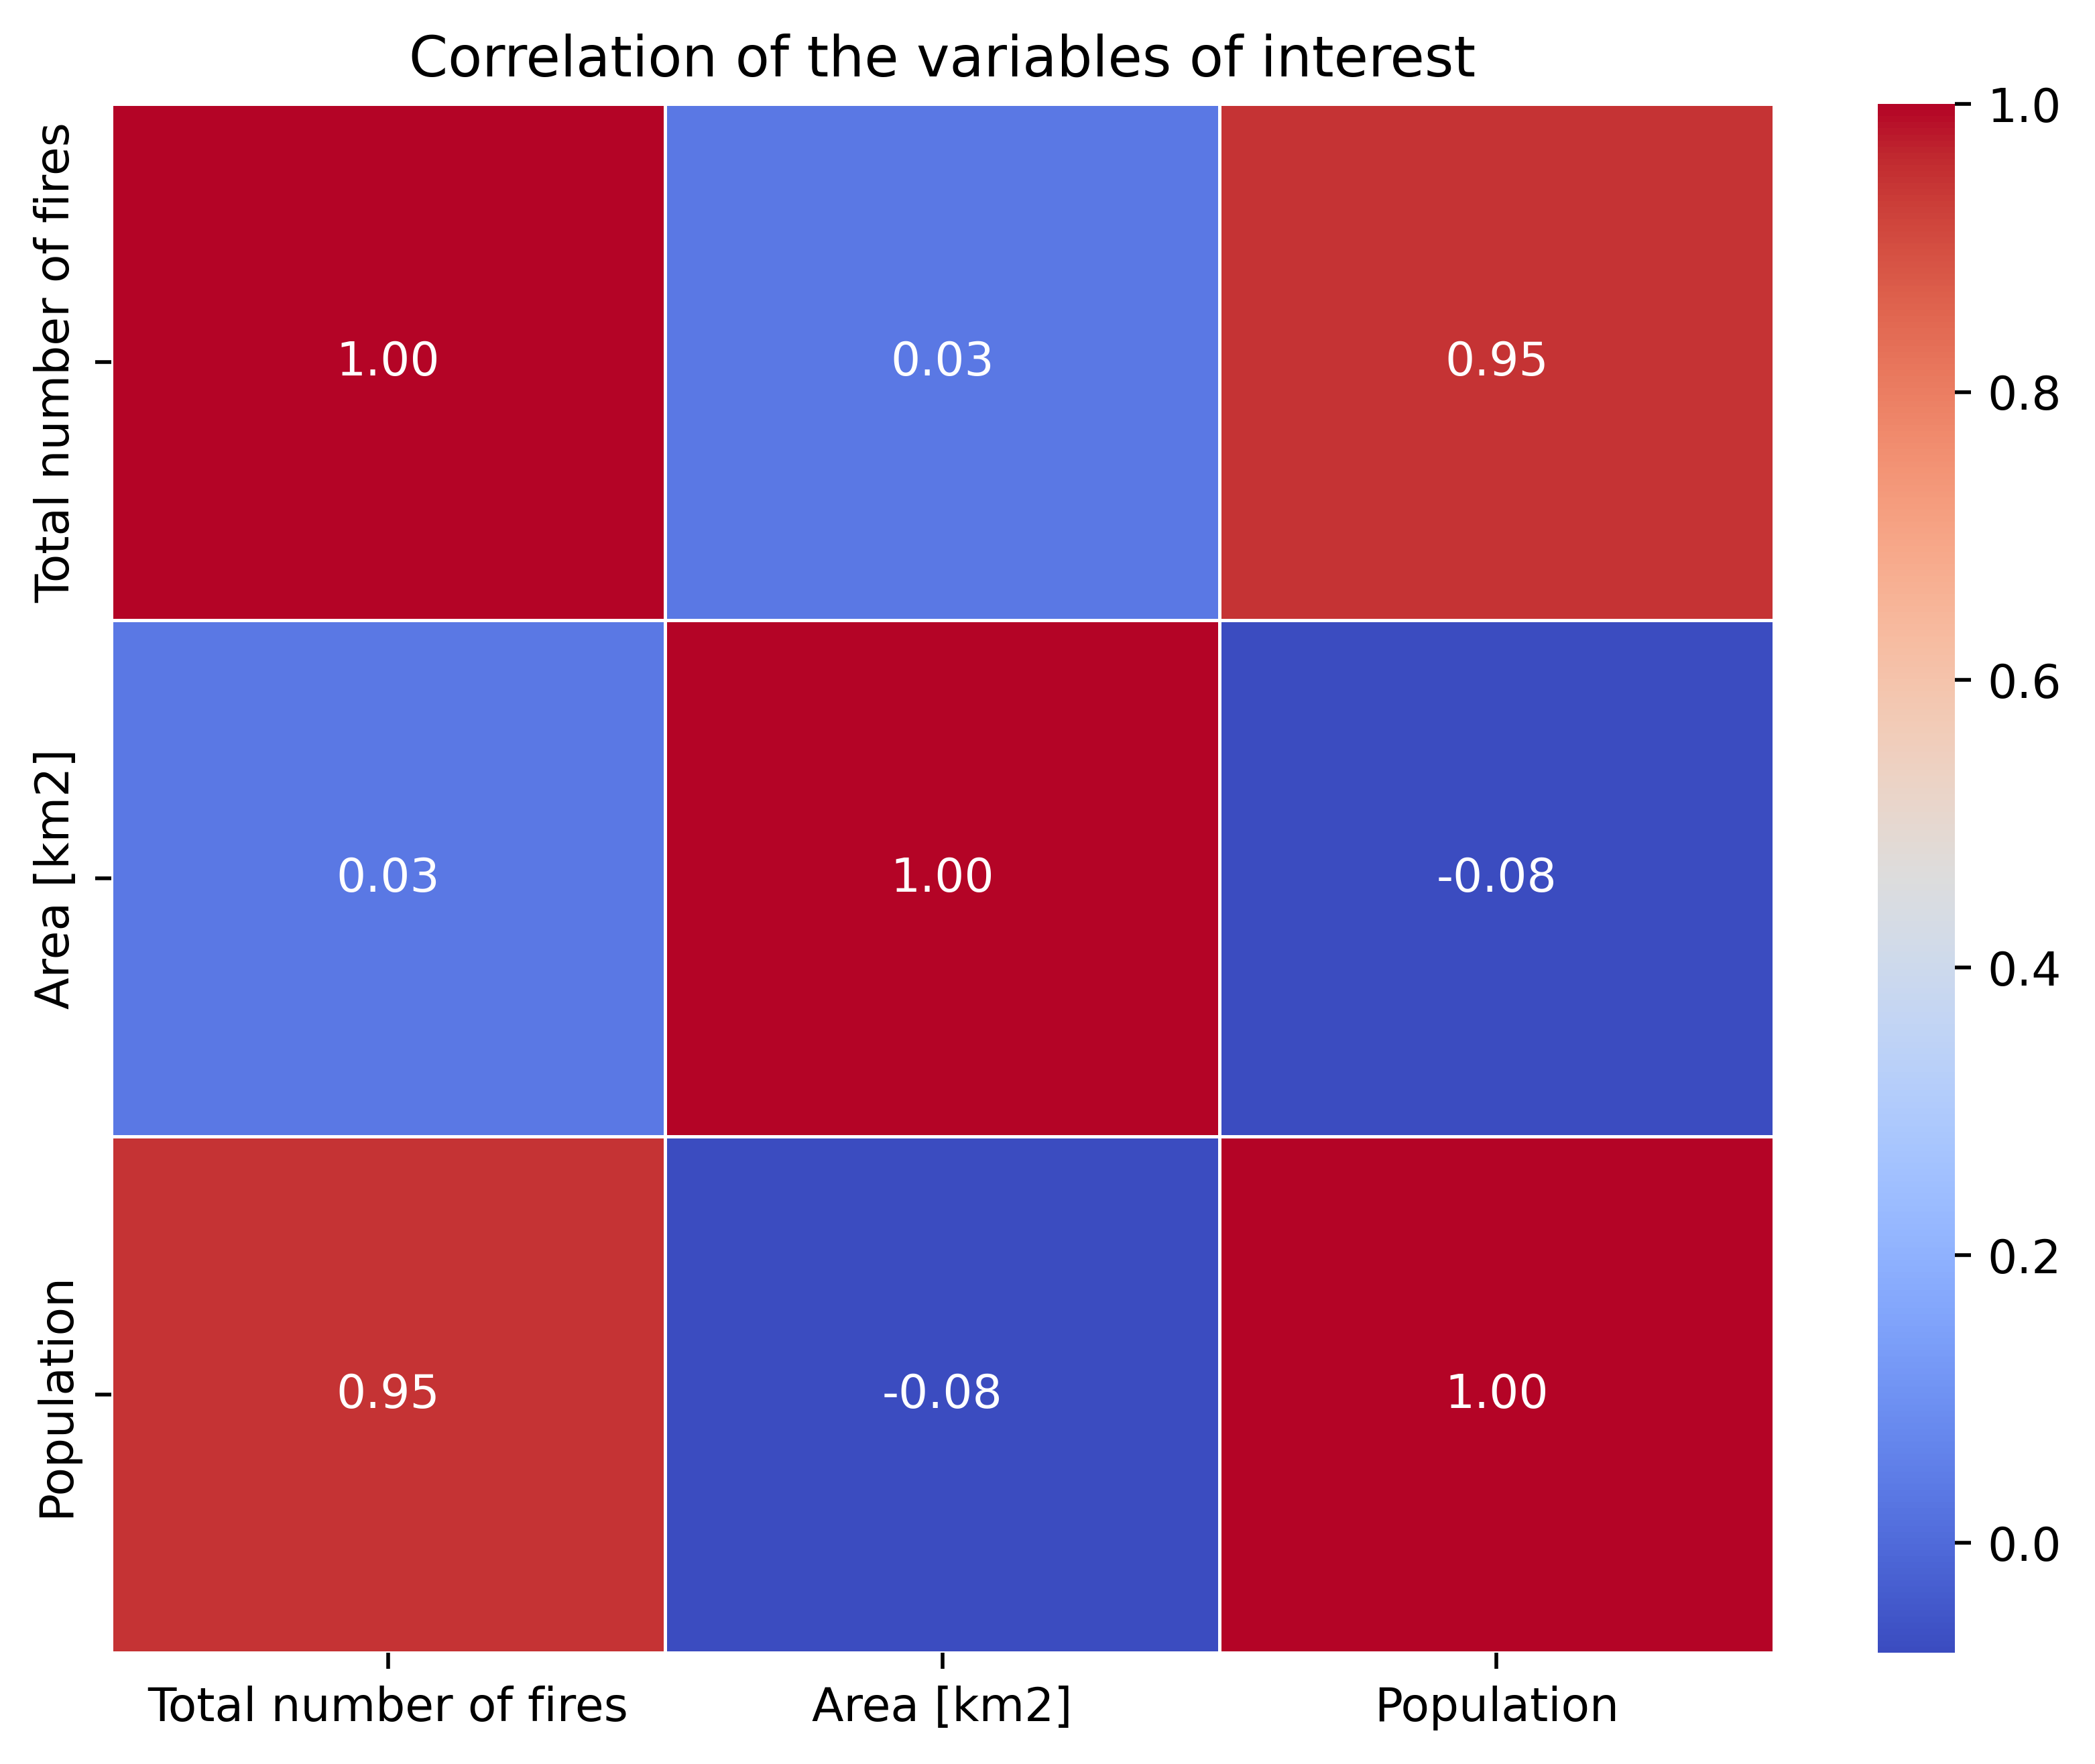

In [26]:
stf.corr_plot(df_pow, ['Total number of fires', 'Area [km2]', 'Population'], output_folder=output_folder_path, filename='corr_pow.png')

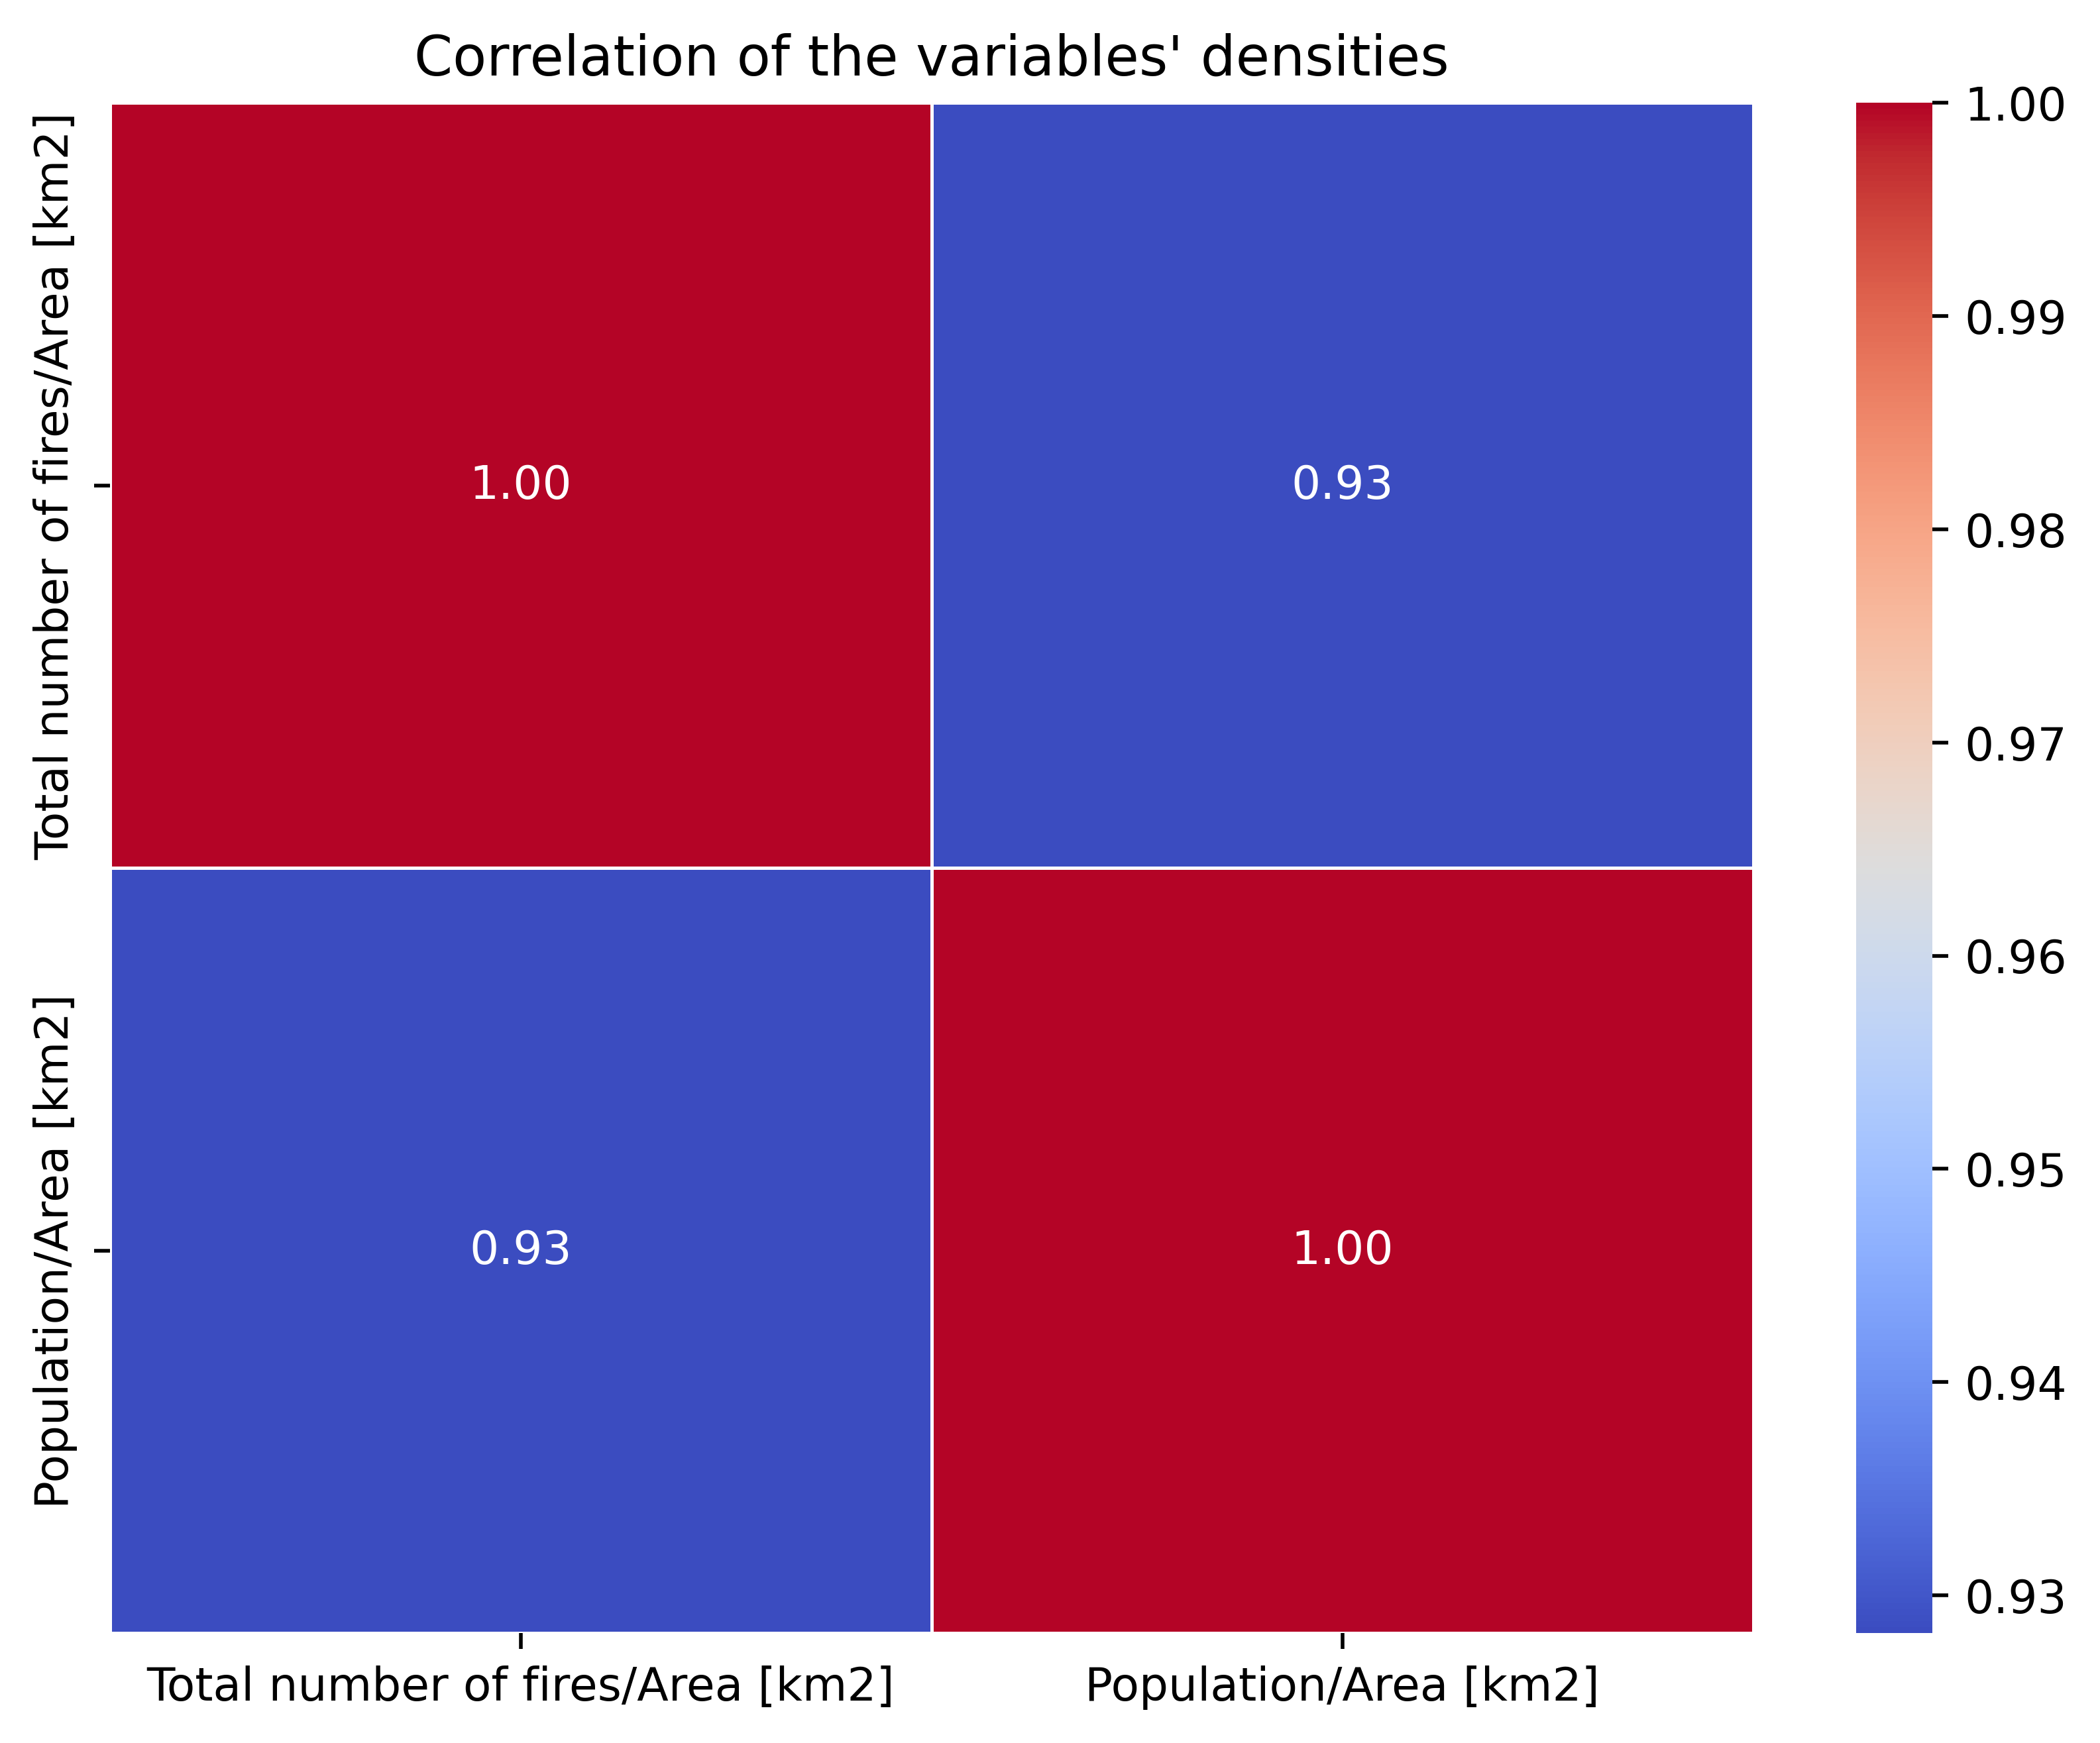

In [37]:
stf.density_corr_plot(df_pow.copy(), ['Total number of fires', 'Population'], area='Area [km2]', output_folder=output_folder_path, filename='density_corr_pow.png')

**Hypothesis for powiat data:**

1. The number of people living in a powiat and the number of fire events are positively correlated.
2. My hypothesis: Number of fires and area of a powiat are not correlated.
3. My hypothesis: Density of the population and fire events are positively correlated.

In [39]:
# The number of people living in an area and the number of fire events,
stf.corr_test(df_pow['Population'], df_pow['Total number of fires'], 'Test results for correlation between population and numer of fire events in a powiat', output_folder_path, output_file, overwrite=True, printer=True)

# The number of fires and area of a powiat
stf.corr_test(df_pow['Total number of fires'], df_pow['Area [km2]'], 'Test results for correlation between number of fire events and area of a powiat', output_folder_path, output_file, printer=True)

# Density of population and fire events
x = df_pow['Population'] / df_pow['Area [km2]']
y = df_pow['Total number of fires'] / df_pow['Area [km2]']
stf.corr_test(x, y, 'Test results for correlation between the density of population and fire events in a powiat', output_folder_path, output_file, printer=True)


Test results for correlation between population and numer of fire events in a powiat: 
0.95 3.7682265449499654e-188
Test results for correlation between number of fire events and area of a powiat: 
0.03 0.5116531530993997
Test results for correlation between the density of population and fire events in a powiat: 
0.93 2.155621055877962e-164


**Conclusion**: The analysis revealed that only the first and last correlations were statistically significant (p < 0.001), with Pearson's r values of 0.95 and 0.93, respectively. These results suggest that powiats with higher populations tend to experience more fire events. At the same time, correlation between fire events and area was not significant, r=0.03, p =0.51. Second and third hypothesis together indicate that the number of fires events is related only to the population, but not the area at the level of powiats.

## By Gmina

In [29]:
territory_level = 'g'

file_list = ['data_population_'+territory_level+'.xls', 'data_area.xlsx', 'data_alcohol_stores.csv', 'data_fire_events.csv']
output_file = 'corr_results'+territory_level+'.txt'

In [30]:
df_population_all, df_area_all, df_alcohol_all, df_fire_events_all = dp.load_data(data_folder_path, file_list)

In [31]:
df_population, df_area, _, df_fire_events = dp.relevant_data_prep_and_rename(df_population_all, df_area_all, df_alcohol_all, df_fire_events_all, territory_level)

In [32]:
df_gm, df_population_gm, df_area_gm, df_fire_events_gm, dropped = dp.by_gmina(df_population, df_area, df_fire_events)

Let's see what information is lost due to dropping rows with missing data:

In [33]:
dropped

,Territory code,Gmina_x,Area [km2],Gmina_y,Population,Gmina,Total number of fires
168,26402,NaN,NaN,NaN,NaN,Wrocław,431.0
169,26403,NaN,NaN,NaN,NaN,Wrocław,397.0
170,26404,NaN,NaN,NaN,NaN,Wrocław,261.0
171,26405,NaN,NaN,NaN,NaN,Wrocław,177.0
172,26406,NaN,NaN,NaN,NaN,Wrocław,247.0
788,106102,Łódź-Bałuty - delegatura,79.0,NaN,NaN,Łódź,318.0
789,106103,Łódź-Górna - delegatura,72.0,NaN,NaN,Łódź,285.0
790,106104,Łódź-Polesie - delegatura,45.0,NaN,NaN,Łódź,197.0
791,106105,Łódź-Śródmieście - delegatura,7.0,NaN,NaN,Łódź,131.0
792,106106,Łódź-Widzew - delegatura,90.0,NaN,NaN,Łódź,249.0


### Correlation analysis

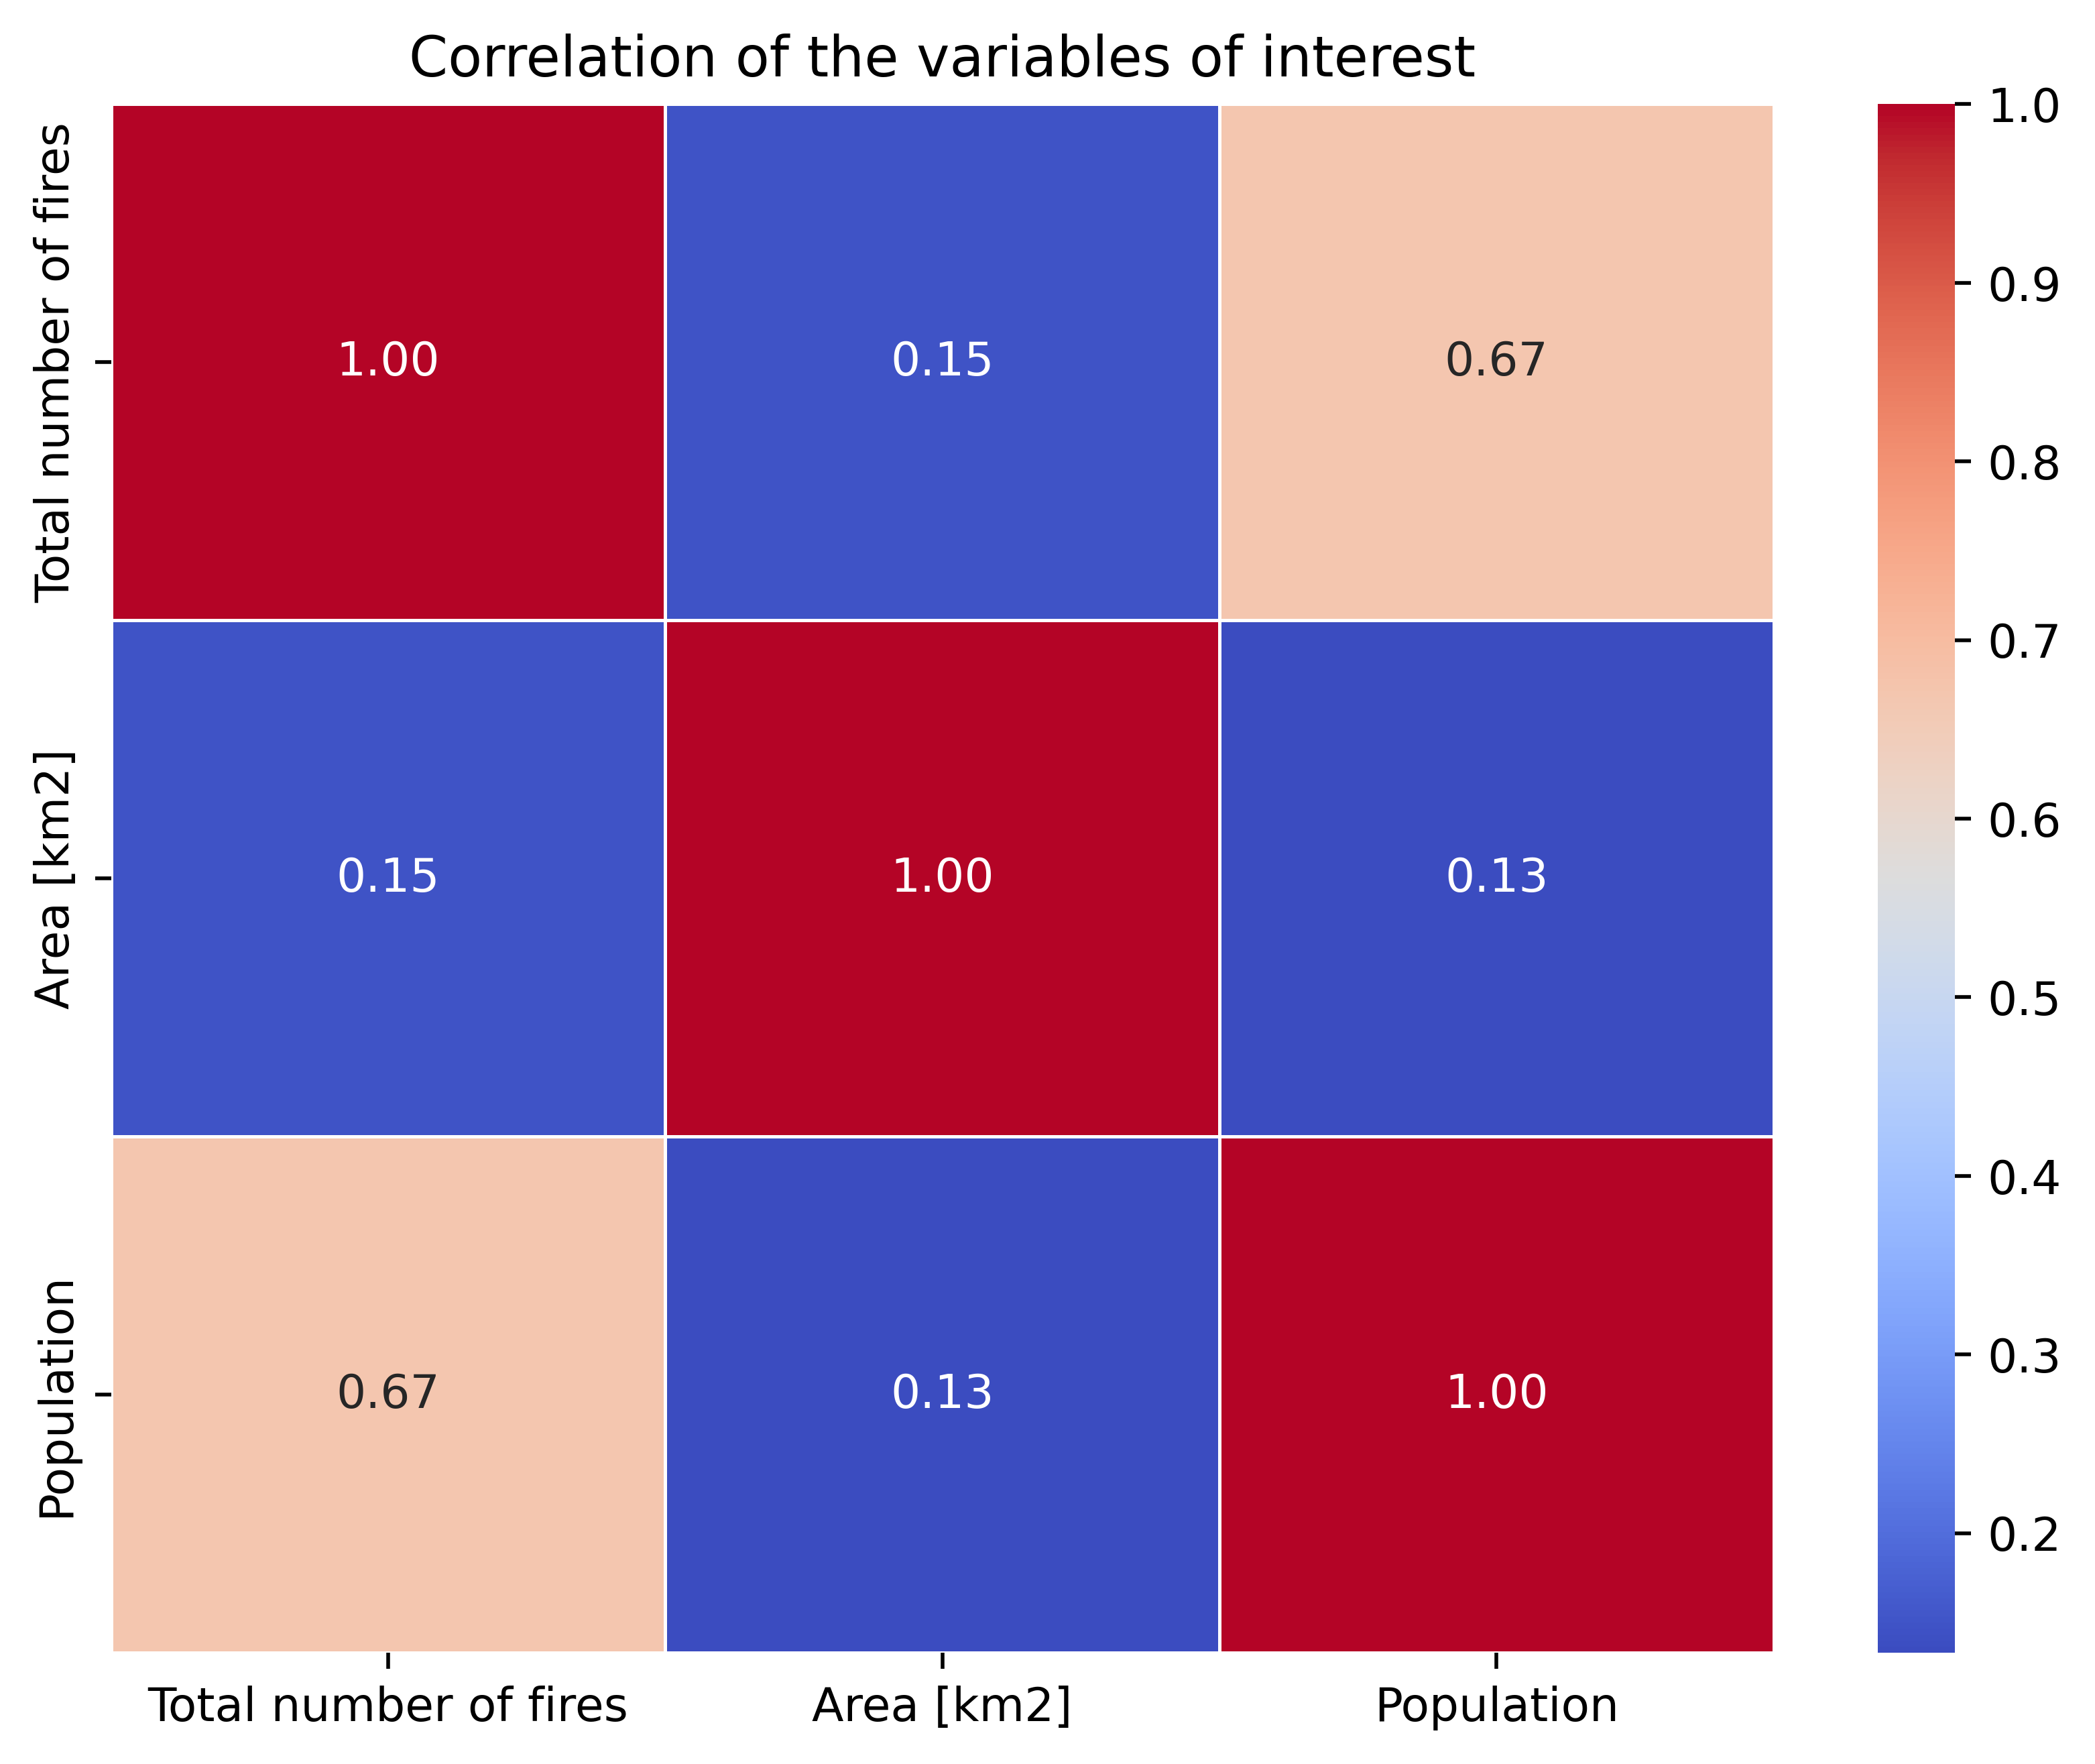

In [34]:
stf.corr_plot(df_gm, ['Total number of fires', 'Area [km2]', 'Population'], output_folder=output_folder_path, filename='corr_gm.png')

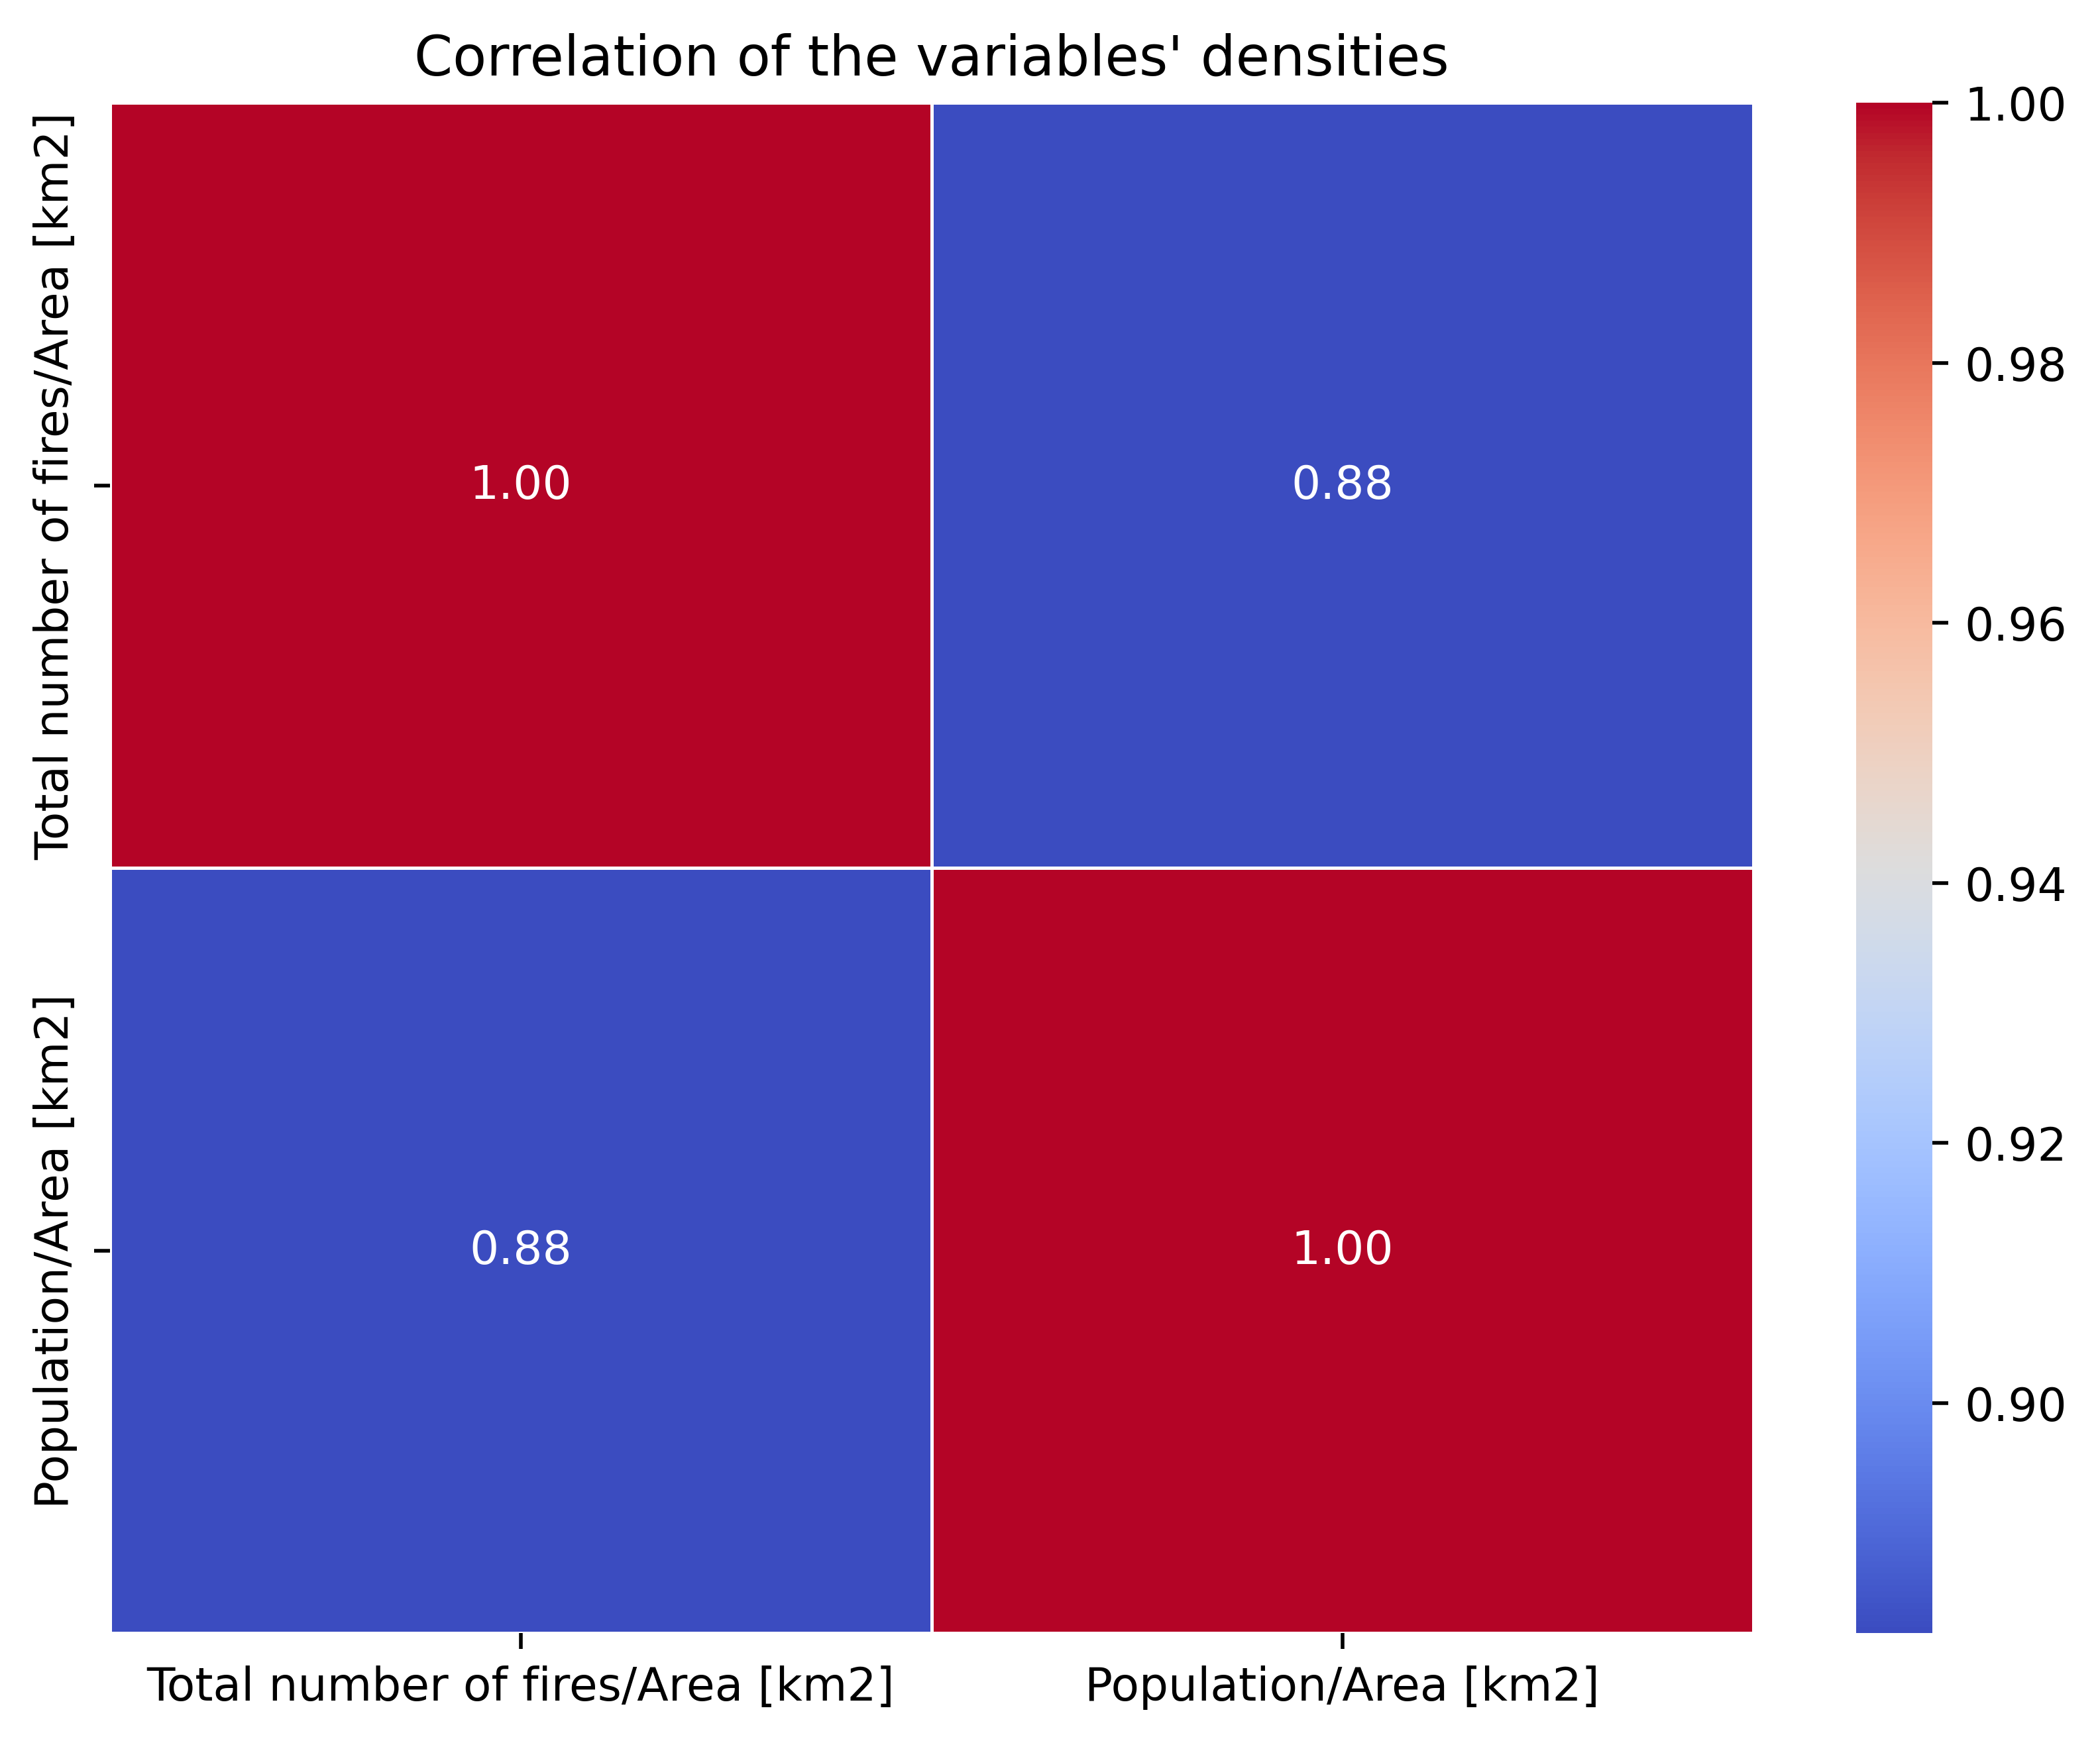

In [35]:
stf.density_corr_plot(df_gm.copy(), ['Total number of fires', 'Population'], area='Area [km2]', output_folder=output_folder_path, filename='density_corr_gm.png')

**Hypothesis for gmina data (same as for powiats):**

1. The number of people living in a gmina and the number of fire events are positively correlated.
2. My hypothesis: Number of fires and area of a gmina are not correlated.
3. My hypothesis: Density of the population and fire events are positively correlated.

In [36]:
# The number of people living in an area and the number of fire events,
stf.corr_test(df_gm['Population'], df_gm['Total number of fires'], 'Test results for correlation between population and numer of fire events in a gmina', output_folder_path, output_file, overwrite=True, printer=True)

# The number of fires and area of a gmina
stf.corr_test(df_gm['Total number of fires'], df_gm['Area [km2]'], 'Test results for correlation between number of fire events and area of a gmina', output_folder_path, output_file, printer=True)

# Density of population and fire events
x = df_gm['Population'] / df_gm['Area [km2]']
y = df_gm['Total number of fires'] / df_gm['Area [km2]']
stf.corr_test(x, y, 'Test results for correlation between the density of population and fire events in a gmina', output_folder_path, output_file, printer=True)


Test results for correlation between population and numer of fire events in a gmina: 
0.67 0.0
Test results for correlation between number of alcohol stores and area of a gmina: 
0.15 1.343831492380908e-13
Test results for correlation between the density of population and fire events in a gmina: 
0.88 0.0


**Conclusion**: The analysis revealed that all three tested correlations were statistically significant (p < 0.001), with Pearson's r values of 0.67, 0.15, and 0.88, respectively. These results suggest that gminas with higher populations tend to experience more fire events. At the same time, area of a gmina is weakly correlated with the number of fire events. Additionally, when controlling for area (the third hypothesis), the association between fire events and population is even more robust, suggesting that population density, rather than absolute value, is a better predictor of the number of fire events.\
Interestingly, those conclusions differ from the indications from the powiat-level analysis.

## Profiling

top cumtime:
- loading data (especially reading excel)
- saving files
- plotting graphs

in data preparation:
- dropping columns
- renaming columns

in by_voivodhip:
- merging dataframes

by_powiat:
- aggregating

In [40]:
!python profile_run_analysis.py

Sun Jun 29 20:17:11 2025    profile.prof

         2956813 function calls (2936687 primitive calls) in 2.111 seconds

   Ordered by: cumulative time
   List reduced from 3989 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   897/12    0.002    0.000    1.303    0.109 text.py:65(_get_text_metrics_with_cache)
     26/4    0.000    0.000    1.302    0.326 text.py:73(_get_text_metrics_with_cache_impl)
     42/4    0.023    0.001    1.272    0.318 backend_agg.py:206(get_text_width_height_descent)
        1    0.000    0.000    1.134    1.134 run_analysis.py:9(load_and_prep)
        1    0.000    0.000    1.104    1.104 data_prep.py:15(load_data)
        2    0.000    0.000    1.085    0.543 _base.py:451(read_excel)
        2    0.000    0.000    0.632    0.316 _base.py:1507(__init__)
        2    0.000    0.000    0.458    0.229 _base.py:546(__init__)
        2    0.000    0.000    0.453    0.227 _base.py:1576(parse)
        2    0.000